#       __Green Skills AI Workshop Final Project__
- Aditya Joshi        22070521016
- Anvesh Khode        22070521021

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import re

In [2]:
file_path =  './MYDATASET.xlsx'

data = pd.ExcelFile(file_path)
data.sheet_names


['Note on Sources',
 'UN reporting',
 'UN reporting source note',
 'ea_total_rate_deficit',
 'ea_urban_rate_deficit',
 'ea_rural_rate_deficit',
 'ea_total_rate_deficit-REFERENCE']

In [3]:
# Mass Encoder Function

def encode_columns(sheets, columns):
    label_encoders = {}
    for col in columns:
        le = LabelEncoder()
        sheets[col] = le.fit_transform(sheets[col])
        label_encoders[col] = le

    return label_encoders

In [4]:
def unique_entries(sheet):
    print("Number of unique entries in: \n")
    for field in sheet:
        var = sheet[field].unique()
        if var.dtype == str:
            print(var)
        var = len(var)
        print(f"{field} : {var}")

---Skip

In [5]:
# UN Reporting Sheet Analysis
un_reporting_data = data.parse('UN reporting')


In [6]:
# Feature Selection
cleaned_data = un_reporting_data.drop(columns=[ 'Reporting Type', 'SeriesCode', 'SeriesID', 'Indicator', 'Units', 'GeoAreaName/Reference Area Name', 'GeoAreaName/Reference Area Name', 'Ref_Area_Type', 'SeriesName', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'FootNote', 'ISOalpha3', 'Source'])
cleaned_data.columns = cleaned_data.columns.str.strip()
cleaned_data = cleaned_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

cleaned_data.head()

C:\Users\Anvesh\AppData\Local\Temp\ipykernel_2888\3275182752.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  cleaned_data = cleaned_data.applymap(lambda x: x.strip() if isinstance(x, str) else x)


,GeoAreaCode/Reference Area Code,TimePeriod,Value,Nature,Location,Type
0,98106,2000,37.7,E,ALLAREA,Region
1,98106,2001,38,E,ALLAREA,Region
2,98106,2002,39,E,ALLAREA,Region
3,98106,2003,40.9,E,ALLAREA,Region
4,98106,2004,40.7,E,ALLAREA,Region


In [7]:
cleaned_data.isnull().sum()

GeoAreaCode/Reference Area Code      0
TimePeriod                           0
Value                                0
Nature                             562
Location                             0
Type                                 0
dtype: int64

In [8]:
# Filling Missing Values

# Nature column, replace NA values with its own label
cleaned_data['Nature'].fillna('NA', inplace = True)
cleaned_data['Nature'].replace('NA ', 'NA', inplace = True)

# Replace 'NaN' values with median
cleaned_data['Value'].replace('NaN', cleaned_data['Value'].median())

cleaned_data.head()

C:\Users\Anvesh\AppData\Local\Temp\ipykernel_2888\2037605223.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_data['Nature'].fillna('NA', inplace = True)


,GeoAreaCode/Reference Area Code,TimePeriod,Value,Nature,Location,Type
0,98106,2000,37.7,E,ALLAREA,Region
1,98106,2001,38,E,ALLAREA,Region
2,98106,2002,39,E,ALLAREA,Region
3,98106,2003,40.9,E,ALLAREA,Region
4,98106,2004,40.7,E,ALLAREA,Region


In [9]:
print(cleaned_data.isnull().sum())

index = 0
for row in cleaned_data['Nature']:
    if row == 'NA':
        index = index+1

print(f"Nature elements which are 'NA': ", index)
print("Dropping rows...")
cleaned_data = cleaned_data[cleaned_data['Nature'] != 'NA']
print(f"Nature elements which are 'NA': ", sum(cleaned_data['Nature'] == 'NA'))


GeoAreaCode/Reference Area Code    0
TimePeriod                         0
Value                              0
Nature                             0
Location                           0
Type                               0
dtype: int64
Nature elements which are 'NA':  563
Dropping rows...
Nature elements which are 'NA':  0


In [10]:
unique_entries(cleaned_data)

Number of unique entries in: 

GeoAreaCode/Reference Area Code : 320
TimePeriod : 23
Value : 1163
Nature : 4
Location : 3
Type : 2


In [11]:
# Label Encode the Data

columns_to_encode = ['Location', 'Type', 'Nature', 'TimePeriod', 'GeoAreaCode/Reference Area Code']

label_encoders = encode_columns(cleaned_data, columns_to_encode)

cleaned_data.head()



,GeoAreaCode/Reference Area Code,TimePeriod,Value,Nature,Location,Type
0,257,0,37.7,1,0,1
1,257,1,38,1,0,1
2,257,2,39,1,0,1
3,257,3,40.9,1,0,1
4,257,4,40.7,1,0,1


In [25]:
cleaned_data['GeoAreaCode/Reference Area Code'].nunique()

320

C:\Users\Anvesh\AppData\Local\Temp\ipykernel_2888\3055818968.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


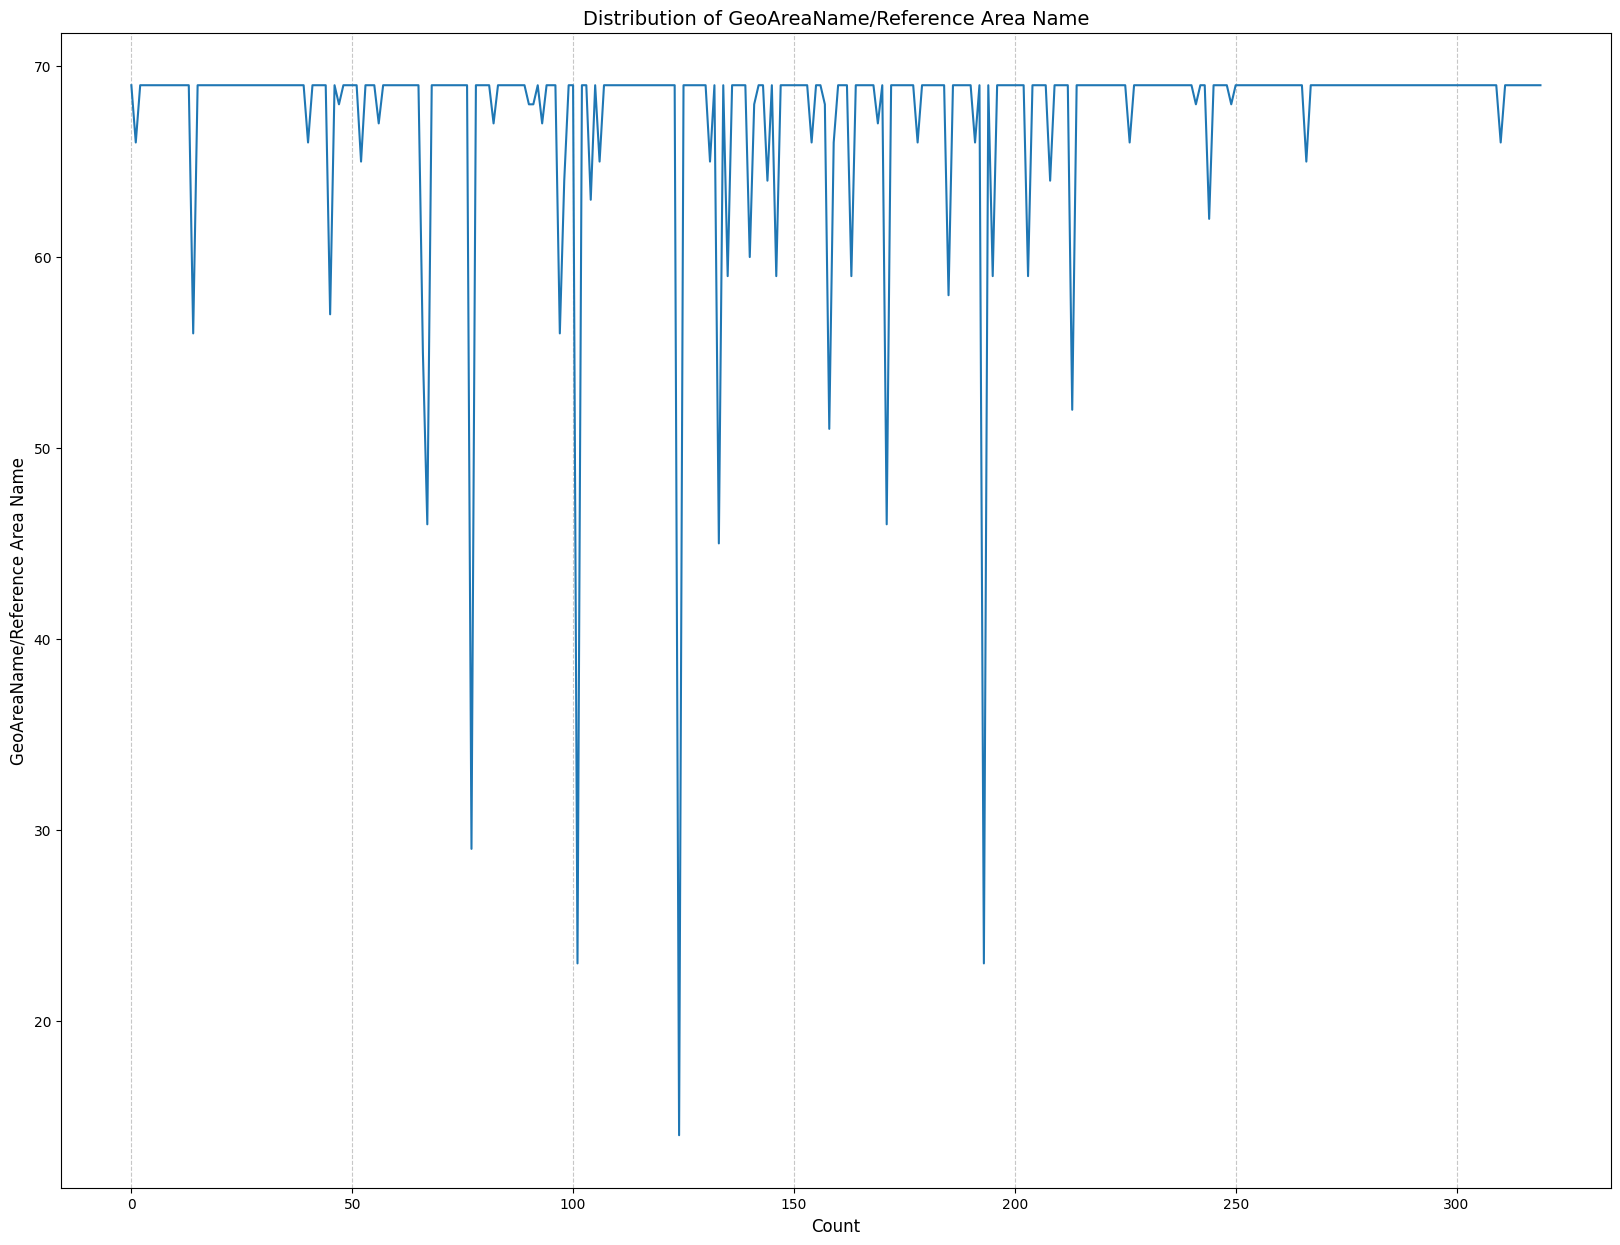

In [30]:

np.random.seed(42)
categories = np.array(['ECA: African Union Commission', 'ECA: All countries', 
                       'ECA: AMU', 'ECA: CEN-SAD', 'ECA: Central Africa', 'ECA: COMESA',
                       'ECA: EAC', 'Afghanistan', 'Albania', 'India', 'United States of America', 
                       'Zimbabwe'])  # Use a subset of categories

n_data_points = 20000
geo_area_names = np.random.choice(categories, n_data_points)
graph_data = pd.DataFrame({'GeoAreaName/Reference Area Name': geo_area_names})

# Count the occurrences of each category
counts = cleaned_data['GeoAreaCode/Reference Area Code'].value_counts()
# counts = counts[0:1]

# Sort by counts for better visualization
counts = counts.sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(20, 15))
sns.lineplot(
    x=counts.index,
    y=counts.values,
    palette='viridis'
)

# Add labels and title
plt.xlabel('Count', fontsize=12)
plt.ylabel('GeoAreaName/Reference Area Name', fontsize=12)
plt.title('Distribution of GeoAreaName/Reference Area Name', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# plt.tight_layout()
plt.show()


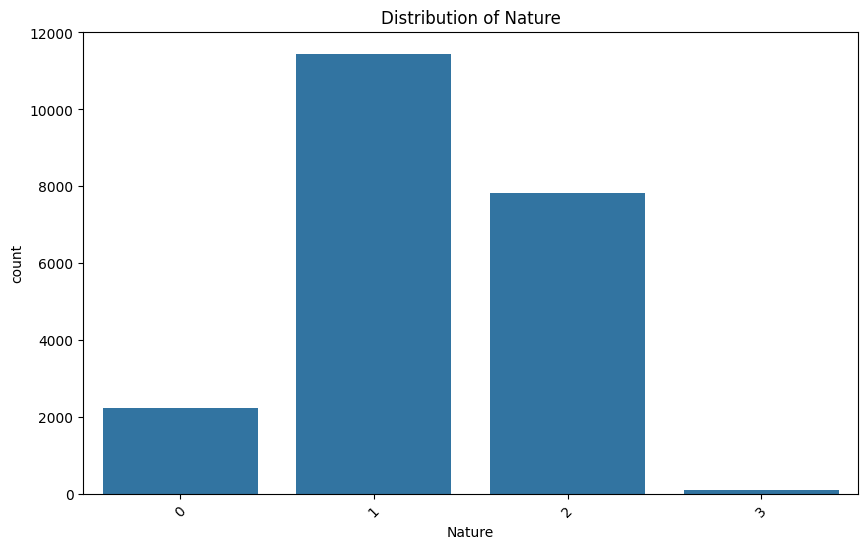

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=cleaned_data, x='Nature')
plt.title('Distribution of Nature')
plt.xticks(rotation=45)
plt.show()


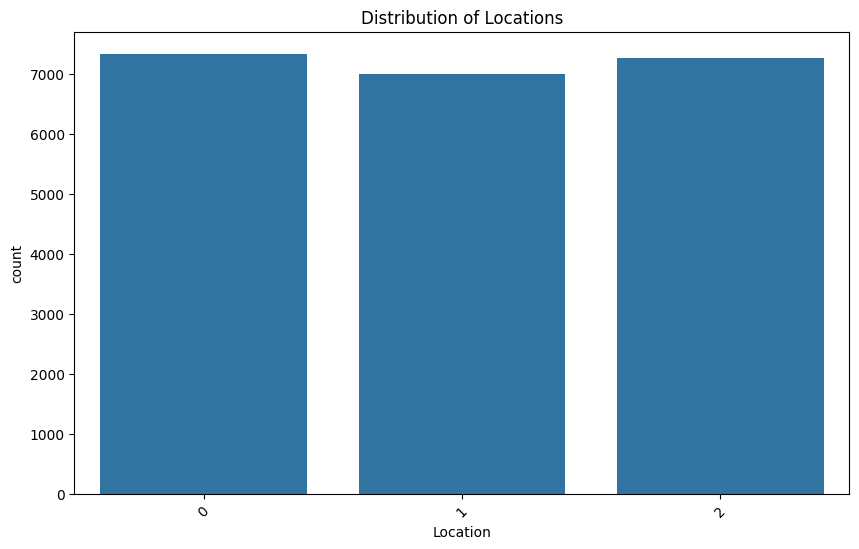

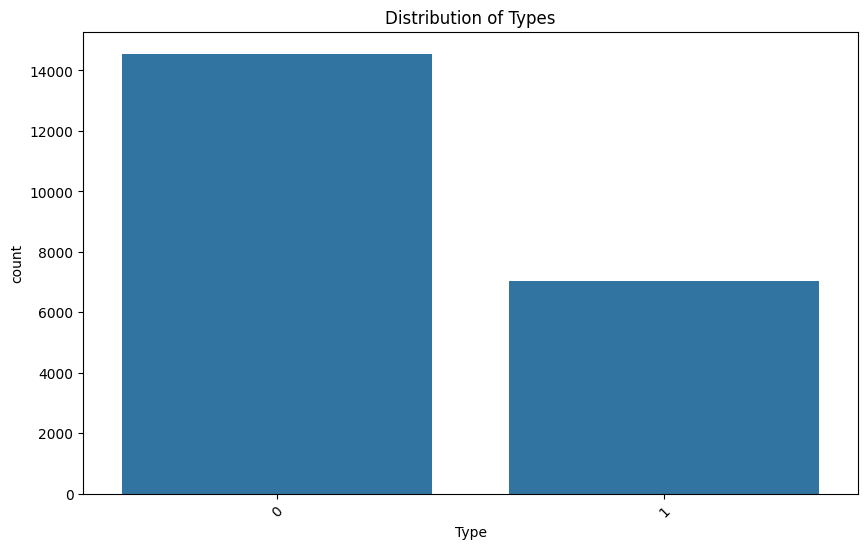

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(data=cleaned_data, x='Location')
plt.title('Distribution of Locations')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=cleaned_data, x='Type')
plt.title('Distribution of Types')
plt.xticks(rotation=45)
plt.show()


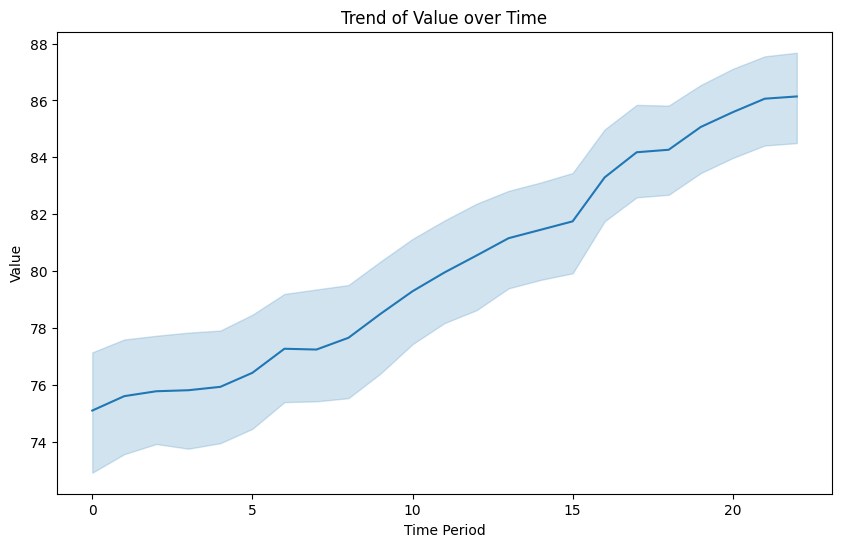

In [15]:
# Assuming TimePeriod is numeric or can be converted to a time format
plt.figure(figsize=(10, 6))
sns.lineplot(data=cleaned_data, x='TimePeriod', y='Value')
plt.title('Trend of Value over Time')
plt.xlabel('Time Period')
plt.ylabel('Value')
plt.show()

# EDA 2.0

In [16]:
data.sheet_names

['Note on Sources',
 'UN reporting',
 'UN reporting source note',
 'ea_total_rate_deficit',
 'ea_urban_rate_deficit',
 'ea_rural_rate_deficit',
 'ea_total_rate_deficit-REFERENCE']

In [17]:
ea_total_rate_deficit = data.parse('ea_total_rate_deficit', usecols=list(range(49)))
ea_total_rate_deficit

,Country/Regional and global averages,Region,2000,2001,2002,2003,2004,2005,2006,2007,...,2013.1,2014.1,2015.1,2016.1,2017.1,2018.1,2019.1,2020.1,2021.1,2022.1
0,Afghanistan,Central Asia and Southern Asia,4.446891,9.294527,14.133616,18.971165,23.814182,28.669672,33.544418,38.440002,...,1.008029e+07,3.435202e+06,9.619747e+06,7.966328e+05,8.197986e+05,2.410000e+06,8.686985e+05,8.963613e+05,9.222876e+05,6.045929e+06
1,Albania,Northern America and Europe,99.430855,99.421989,99.404579,99.385628,99.372139,99.371124,99.389366,99.428452,...,3.175563e+03,1.444552e+03,5.761406e+02,3.163711e+03,3.160803e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,Algeria,Western Asia and Northern Africa,98.640030,98.637970,98.627357,98.615211,98.608528,98.614319,98.700000,98.685249,...,3.085927e+05,2.811851e+05,2.545814e+05,2.284445e+05,1.933329e+05,1.518843e+05,2.135268e+05,1.221979e+05,9.373393e+04,7.095159e+04
3,American Samoa,Oceania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00
4,Andorra,Northern America and Europe,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,Western Asia and Northern Africa,NaN,88.073284,88.650167,88.580416,89.260560,89.133464,89.697461,91.420104,89.862460,...,3.231626e+07,3.501580e+07,3.479727e+07,3.347274e+07,2.949568e+07,3.627430e+07,3.154637e+07,3.081990e+07,3.024835e+07,2.988148e+07
225,Sub-Saharan Africa,NaN,25.798302,26.012223,27.219305,29.540140,29.311852,29.274155,31.168640,32.533935,...,5.728383e+08,5.860097e+08,5.947437e+08,5.639254e+08,5.804772e+08,5.677724e+08,5.749707e+08,5.756052e+08,5.666395e+08,5.712388e+08
226,Oceania,NaN,81.595715,81.466043,81.369678,81.243673,81.109301,81.017766,80.398437,80.840325,...,7.429488e+06,7.494825e+06,7.602015e+06,8.186205e+06,7.800237e+06,8.208796e+06,7.681359e+06,8.099672e+06,8.236045e+06,8.547971e+06
227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Dropping null values
ea_total_rate_deficit.dropna(inplace=True)
ea_total_rate_deficit.isna().sum()


Country/Regional and global averages    0
Region                                  0
2000                                    0
2001                                    0
2002                                    0
2003                                    0
2004                                    0
2005                                    0
2006                                    0
2007                                    0
2008                                    0
2009                                    0
2010                                    0
2011                                    0
2012                                    0
2013                                    0
2014                                    0
2015                                    0
2016                                    0
2017                                    0
2018                                    0
2019                                    0
2020                                    0
2021                              

In [19]:
unique_entries(ea_total_rate_deficit)

Number of unique entries in: 

Country/Regional and global averages : 214
2000_percentage : 151
2001_percentage : 153
2002_percentage : 150
2003_percentage : 157
2004_percentage : 157
2005_percentage : 157
2006_percentage : 150
2007_percentage : 146
2008_percentage : 144
2009_percentage : 142
2010_percentage : 141
2011_percentage : 140
2012_percentage : 135
2013_percentage : 137
2014_percentage : 128
2015_percentage : 125
2016_percentage : 122
2017_percentage : 112
2018_percentage : 112
2019_percentage : 105
2020_percentage : 102
2021_percentage : 90
Cluster : 3
Predicted_Cluster : 3


,Country/Regional and global averages,2000_percentage,2001_percentage,2002_percentage,2003_percentage,2004_percentage,2005_percentage,2006_percentage,2007_percentage,2008_percentage,...,2014_percentage,2015_percentage,2016_percentage,2017_percentage,2018_percentage,2019_percentage,2020_percentage,2021_percentage,Cluster,Predicted_Cluster
0,0,4.446891,9.294527,14.133616,18.971165,23.814182,28.669672,33.544418,38.440002,42.400000,...,89.500000,71.500000,97.700000,97.700000,93.430878,97.700000,97.700000,97.700000,1,1
1,1,99.430855,99.421989,99.404579,99.385628,99.372139,99.371124,99.389366,99.428452,100.000000,...,99.950000,99.980000,99.890000,99.890000,100.000000,100.000000,100.000000,100.000000,0,0
2,2,98.640030,98.637970,98.627357,98.615211,98.608528,98.614319,98.700000,98.685249,99.300000,...,99.274551,99.356194,99.433693,99.530022,99.637741,99.500000,99.718773,99.787827,0,0
4,3,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0,0
5,4,24.238865,20.000000,26.320255,27.355137,28.395485,29.448309,30.520388,37.500000,38.490000,...,32.000000,42.000000,41.785034,42.906242,45.290000,45.633881,46.955444,48.223854,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,209,98.900000,99.900000,99.800000,95.700000,99.100000,98.776756,99.300000,98.852371,98.917816,...,100.000000,100.000000,99.400000,99.200000,99.878197,99.844780,99.916321,99.987717,0,0
215,210,88.235100,88.919899,89.100000,90.270866,90.951042,96.100000,96.000000,93.088356,93.838333,...,99.200000,99.254211,99.200000,100.000000,100.000000,99.400000,99.800000,100.000000,0,0
216,211,49.239231,50.364323,51.480869,52.595875,49.590000,54.849293,55.800335,57.174534,58.364799,...,66.100000,67.414886,68.855865,79.200000,62.000000,72.776573,73.853462,74.877197,1,1
217,212,16.700000,20.208212,17.400000,18.500000,20.300000,23.282736,24.082327,18.500000,25.740410,...,27.900000,31.100000,35.377220,40.300000,40.229340,43.000000,44.604069,46.685116,2,2


In [44]:
# Label Encoding the columns

columns_to_encode_2 = ['2022 data sources', 'Region', 'Country/Regional and global averages']

label_encoders_2 = encode_columns(ea_total_rate_deficit, columns_to_encode_2)
ea_total_rate_deficit.head()
label_encoders_2

KeyError: '2022 data sources'

In [21]:
# Splitting the dataset into countries with percentage electricity access and count of people without electricity access

access_percentage = ea_total_rate_deficit.iloc[:, 3:24]
access_percentage.columns = access_percentage.columns.astype(str)
access_percentage = access_percentage.add_suffix('_percentage')

without_access = ea_total_rate_deficit.iloc[:, 27:48]
without_access.columns = without_access.columns.astype(str)
without_access.columns = without_access.columns.str.replace('.1', '', regex=False)
without_access = without_access.add_suffix('_without')

access_percentage['Country'] = ea_total_rate_deficit['Country/Regional and global averages']
access_percentage['Region'] = ea_total_rate_deficit['Region']

without_access['Country'] = ea_total_rate_deficit['Country/Regional and global averages']
without_access['Region'] = ea_total_rate_deficit['Region']

print("Access Percentage Columns:")
print(access_percentage.columns)

print("\nWithout Access Columns:")
print(without_access.columns)


Access Percentage Columns:
Index(['2001_percentage', '2002_percentage', '2003_percentage',
       '2004_percentage', '2005_percentage', '2006_percentage',
       '2007_percentage', '2008_percentage', '2009_percentage',
       '2010_percentage', '2011_percentage', '2012_percentage',
       '2013_percentage', '2014_percentage', '2015_percentage',
       '2016_percentage', '2017_percentage', '2018_percentage',
       '2019_percentage', '2020_percentage', '2021_percentage', 'Country',
       'Region'],
      dtype='object')

Without Access Columns:
Index(['2001_without', '2002_without', '2003_without', '2004_without',
       '2005_without', '2006_without', '2007_without', '2008_without',
       '2009_without', '2010_without', '2011_without', '2012_without',
       '2013_without', '2014_without', '2015_without', '2016_without',
       '2017_without', '2018_without', '2019_without', '2020_without',
       '2021_without', 'Country', 'Region'],
      dtype='object')


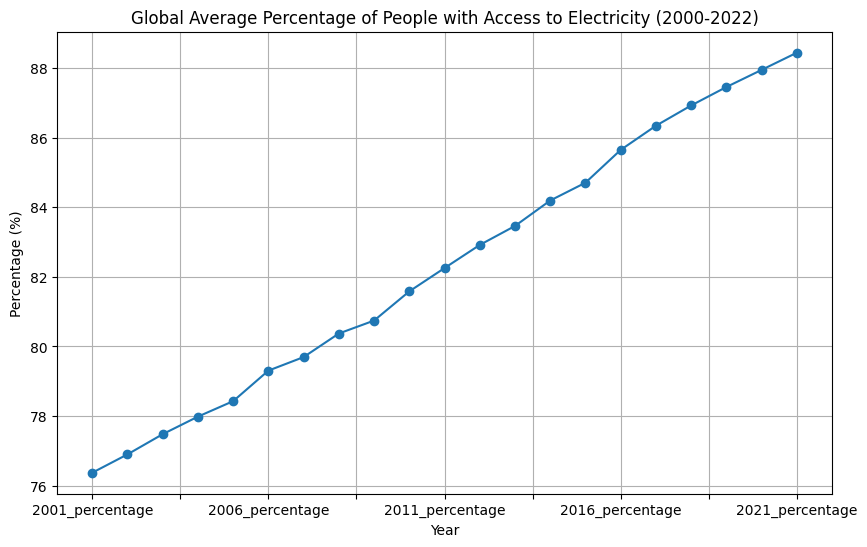

In [ ]:
# Calculate global average for each year
global_avg = access_percentage.drop(columns=['Country', 'Region']).mean()

# Plot

plt.figure(figsize=(10, 6))
global_avg.plot(kind='line', marker='o')
plt.title('Global Average Percentage of People with Access to Electricity (2000-2022)')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.grid()
plt.show()


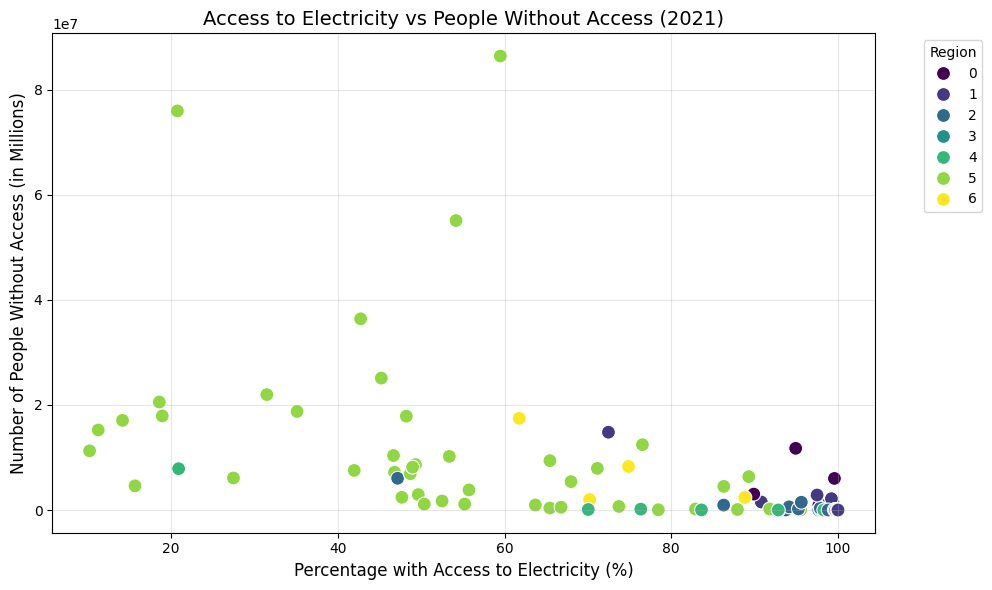

In [ ]:



# Example year for comparison (ensure this column exists)
year = '2021'

# Merge the two DataFrames based on the 'Country' column
merged_df = access_percentage.merge(without_access, on=['Country', 'Region'], suffixes=('_percentage', '_without'))

# Ensure we have correct columns for the selected year
merged_df = merged_df.dropna(subset=[f'{year}_percentage', f'{year}_without'])

merged_df['Region'] = label_encoders_2['Region']

# Scatterplot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=merged_df[f'{year}_percentage'],
    y=merged_df[f'{year}_without'],
    hue=merged_df['Region'],  # Color by region
    palette='viridis',
    s=100
)

# Titles and labels
plt.title(f"Access to Electricity vs People Without Access ({year})", fontsize=14)
plt.xlabel("Percentage with Access to Electricity (%)", fontsize=12)
plt.ylabel("Number of People Without Access (in Millions)", fontsize=12)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()


In [61]:
access_percentage


,2001_percentage,2002_percentage,2003_percentage,2004_percentage,2005_percentage,2006_percentage,2007_percentage,2008_percentage,2009_percentage,2010_percentage,...,2014_percentage,2015_percentage,2016_percentage,2017_percentage,2018_percentage,2019_percentage,2020_percentage,2021_percentage,Country,Region
0,9.294527,14.133616,18.971165,23.814182,28.669672,33.544418,38.440002,42.400000,48.279007,42.700000,...,89.500000,71.500000,97.700000,97.700000,93.430878,97.700000,97.700000,97.700000,0,0
1,99.421989,99.404579,99.385628,99.372139,99.371124,99.389366,99.428452,100.000000,99.554451,99.644203,...,99.950000,99.980000,99.890000,99.890000,100.000000,100.000000,100.000000,100.000000,1,3
2,98.637970,98.627357,98.615211,98.608528,98.614319,98.700000,98.685249,99.300000,98.824860,98.910904,...,99.274551,99.356194,99.433693,99.530022,99.637741,99.500000,99.718773,99.787827,2,6
4,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,3,3
5,20.000000,26.320255,27.355137,28.395485,29.448309,30.520388,37.500000,38.490000,33.846977,34.980053,...,32.000000,42.000000,41.785034,42.906242,45.290000,45.633881,46.955444,48.223854,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,99.900000,99.800000,95.700000,99.100000,98.776756,99.300000,98.852371,98.917816,98.996658,99.085045,...,100.000000,100.000000,99.400000,99.200000,99.878197,99.844780,99.916321,99.987717,209,2
215,88.919899,89.100000,90.270866,90.951042,96.100000,96.000000,93.088356,93.838333,96.100000,97.430000,...,99.200000,99.254211,99.200000,100.000000,100.000000,99.400000,99.800000,100.000000,210,1
216,50.364323,51.480869,52.595875,49.590000,54.849293,55.800335,57.174534,58.364799,59.568451,60.781654,...,66.100000,67.414886,68.855865,79.200000,62.000000,72.776573,73.853462,74.877197,211,6
217,20.208212,17.400000,18.500000,20.300000,23.282736,24.082327,18.500000,25.740410,26.591452,22.000000,...,27.900000,31.100000,35.377220,40.300000,40.229340,43.000000,44.604069,46.685116,212,5


In [60]:
without_access.head()

,2001_without,2002_without,2003_without,2004_without,2005_without,2006_without,2007_without,2008_without,2009_without,2010_without,...,2014_without,2015_without,2016_without,2017_without,2018_without,2019_without,2020_without,2021_without,Country,Region
0,1.785867e+07,1.803216e+07,1.834909e+07,1.794447e+07,1.741258e+07,1.690826e+07,1.594607e+07,1.522207e+07,1.416395e+07,1.615268e+07,...,3.435202e+06,9.619747e+06,7.966328e+05,8.197986e+05,2.410000e+06,8.686985e+05,8.963613e+05,9.222876e+05,0,0
1,1.768812e+04,1.816635e+04,1.867456e+04,1.900497e+04,1.893851e+04,1.827350e+04,1.697509e+04,0.000000e+00,1.304353e+04,1.036444e+04,...,1.444552e+03,5.761406e+02,3.163711e+03,3.160803e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1,3
2,4.249668e+05,4.340940e+05,4.439062e+05,4.523701e+05,4.566746e+05,4.346560e+05,4.468026e+05,2.419871e+05,4.136028e+05,3.905100e+05,...,2.811851e+05,2.545814e+05,2.284445e+05,1.933329e+05,1.518843e+05,2.135268e+05,1.221979e+05,9.373393e+04,2,6
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3,3
5,1.355327e+07,1.290585e+07,1.316640e+07,1.344097e+07,1.372298e+07,1.400872e+07,1.306855e+07,1.334246e+07,1.488951e+07,1.519138e+07,...,1.844727e+07,1.631408e+07,1.697243e+07,1.724724e+07,1.710975e+07,1.758939e+07,1.773199e+07,1.786472e+07,4,5


In [63]:
ea_total_rate_deficit.columns = ea_total_rate_deficit.columns.map(str)

In [64]:
# Assuming 'df' is your DataFrame


def modify_column_name(col):
    if re.match(r'^\d{4}$', col):
        return f"{col}_percentage"
    elif re.match(r'^\d{4}\.1$', col):
        return f"{col.split('.')[0]}_without"
    return col

ea_total_rate_deficit.columns= ea_total_rate_deficit.columns.map(modify_column_name)

In [65]:
new_modified_dff=ea_total_rate_deficit

In [66]:
new_modified_dff.columns

Index(['Country/Regional and global averages', '2000_percentage',
       '2001_percentage', '2002_percentage', '2003_percentage',
       '2004_percentage', '2005_percentage', '2006_percentage',
       '2007_percentage', '2008_percentage', '2009_percentage',
       '2010_percentage', '2011_percentage', '2012_percentage',
       '2013_percentage', '2014_percentage', '2015_percentage',
       '2016_percentage', '2017_percentage', '2018_percentage',
       '2019_percentage', '2020_percentage', '2021_percentage', 'Cluster',
       'Predicted_Cluster'],
      dtype='object')

In [31]:
new_modified_dff.drop([ 'Region','2022 data sources','2000_without', '2001_without',
       '2002_without', '2003_without', '2004_without', '2005_without',
       '2006_without', '2007_without', '2008_without', '2009_without',
       '2010_without', '2011_without', '2012_without', '2013_without',
       '2014_without', '2015_without', '2016_without', '2017_without',
       '2018_without', '2019_without', '2020_without', '2021_without',
       '2022_without', '2022_percentage'],inplace=True,axis=1)

In [32]:
new_modified_dff.head()

,Country/Regional and global averages,2000_percentage,2001_percentage,2002_percentage,2003_percentage,2004_percentage,2005_percentage,2006_percentage,2007_percentage,2008_percentage,...,2012_percentage,2013_percentage,2014_percentage,2015_percentage,2016_percentage,2017_percentage,2018_percentage,2019_percentage,2020_percentage,2021_percentage
0,0,4.446891,9.294527,14.133616,18.971165,23.814182,28.669672,33.544418,38.440002,42.40,...,69.100000,68.040878,89.500000,71.500000,97.700000,97.700000,93.430878,97.700000,97.700000,97.700000
1,1,99.430855,99.421989,99.404579,99.385628,99.372139,99.371124,99.389366,99.428452,100.00,...,99.900000,99.890312,99.950000,99.980000,99.890000,99.890000,100.000000,100.000000,100.000000,100.000000
2,2,98.640030,98.637970,98.627357,98.615211,98.608528,98.614319,98.700000,98.685249,99.30,...,98.764660,99.187927,99.274551,99.356194,99.433693,99.530022,99.637741,99.500000,99.718773,99.787827
4,3,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
5,4,24.238865,20.000000,26.320255,27.355137,28.395485,29.448309,30.520388,37.500000,38.49,...,37.259491,38.398178,32.000000,42.000000,41.785034,42.906242,45.290000,45.633881,46.955444,48.223854


In [ ]:


df=new_modified_dff

# Select columns representing the years (2000-2021)
years_columns = [str(year) + "_percentage" for year in range(2000, 2022)]
data = df[years_columns]
data.head()




,2000_percentage,2001_percentage,2002_percentage,2003_percentage,2004_percentage,2005_percentage,2006_percentage,2007_percentage,2008_percentage,2009_percentage,...,2012_percentage,2013_percentage,2014_percentage,2015_percentage,2016_percentage,2017_percentage,2018_percentage,2019_percentage,2020_percentage,2021_percentage
0,4.446891,9.294527,14.133616,18.971165,23.814182,28.669672,33.544418,38.440002,42.40,48.279007,...,69.100000,68.040878,89.500000,71.500000,97.700000,97.700000,93.430878,97.700000,97.700000,97.700000
1,99.430855,99.421989,99.404579,99.385628,99.372139,99.371124,99.389366,99.428452,100.00,99.554451,...,99.900000,99.890312,99.950000,99.980000,99.890000,99.890000,100.000000,100.000000,100.000000,100.000000
2,98.640030,98.637970,98.627357,98.615211,98.608528,98.614319,98.700000,98.685249,99.30,98.824860,...,98.764660,99.187927,99.274551,99.356194,99.433693,99.530022,99.637741,99.500000,99.718773,99.787827
4,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
5,24.238865,20.000000,26.320255,27.355137,28.395485,29.448309,30.520388,37.500000,38.49,33.846977,...,37.259491,38.398178,32.000000,42.000000,41.785034,42.906242,45.290000,45.633881,46.955444,48.223854


In [34]:

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data

array([[-2.15940332, -2.04626385, -1.94652993, ...,  0.44432067,
         0.42938429,  0.4170504 ],
       [ 0.71318637,  0.7030661 ,  0.697853  , ...,  0.54401391,
         0.5305791 ,  0.52057559],
       [ 0.68926954,  0.67914966,  0.67375017, ...,  0.52234147,
         0.51820574,  0.51102546],
       ...,
       [-0.80475344, -0.79343351, -0.78833452, ..., -0.6359825 ,
        -0.61980958, -0.61022565],
       [-1.78883387, -1.7133429 , -1.84523438, ..., -1.92664475,
        -1.90671691, -1.87917806],
       [-1.27534187, -1.2874243 , -1.3242407 , ..., -1.76704477,
        -1.54841694, -1.77588642]])

In [35]:
# Apply K-Means Clustering (adjust number of clusters as needed)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# View the cluster assignments
print(df['Country/Regional and global averages'].head())
df['Cluster'].head()

0    0
1    1
2    2
4    3
5    4
Name: Country/Regional and global averages, dtype: int64


0    1
1    0
2    0
4    0
5    2
Name: Cluster, dtype: int32

In [36]:
# Find the average electricity access percentage for each cluster in the year 2021
avg_access_2020 = df.groupby('Cluster')['2020_percentage'].mean()
print(avg_access_2020)


Cluster
0    99.006739
1    70.796440
2    32.398167
Name: 2020_percentage, dtype: float64


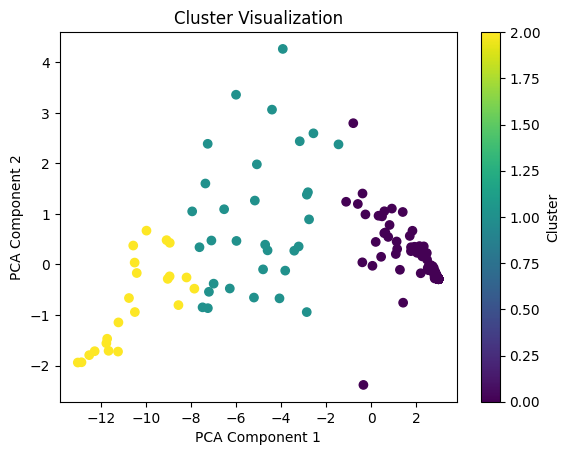

In [ ]:

# Reduce to 2 dimensions using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Plotting the clusters
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [38]:
# Assuming 'df' is your DataFrame and the 'Cluster' column is already added
# Select the columns representing the years (2000-2021) with '_percentage' suffix
years_columns = [str(year) + "_percentage" for year in range(2000, 2022)]

# Group by 'Cluster' and calculate the mean for each year
avg_access_by_cluster = df.groupby('Cluster')[years_columns].mean()

# Print the average electricity access percentage for each cluster in every year
print(avg_access_by_cluster)

         2000_percentage  2001_percentage  2002_percentage  2003_percentage  \
Cluster                                                                       
0              93.577222        93.992871        94.289603        94.518341   
1              32.380685        33.604042        35.049765        36.945471   
2              10.142179        10.451016        11.318412        12.537727   

         2004_percentage  2005_percentage  2006_percentage  2007_percentage  \
Cluster                                                                       
0              94.839566        95.081944        95.676775        95.726195   
1              38.092514        40.145700        42.067115        42.995246   
2              13.436219        13.004464        14.414330        16.484661   

         2008_percentage  2009_percentage  ...  2012_percentage  \
Cluster                                    ...                    
0              96.109123        96.352818  ...        97.389272   
1      

C:\Users\Anvesh\AppData\Local\Temp\ipykernel_23840\2133408454.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1, 1))


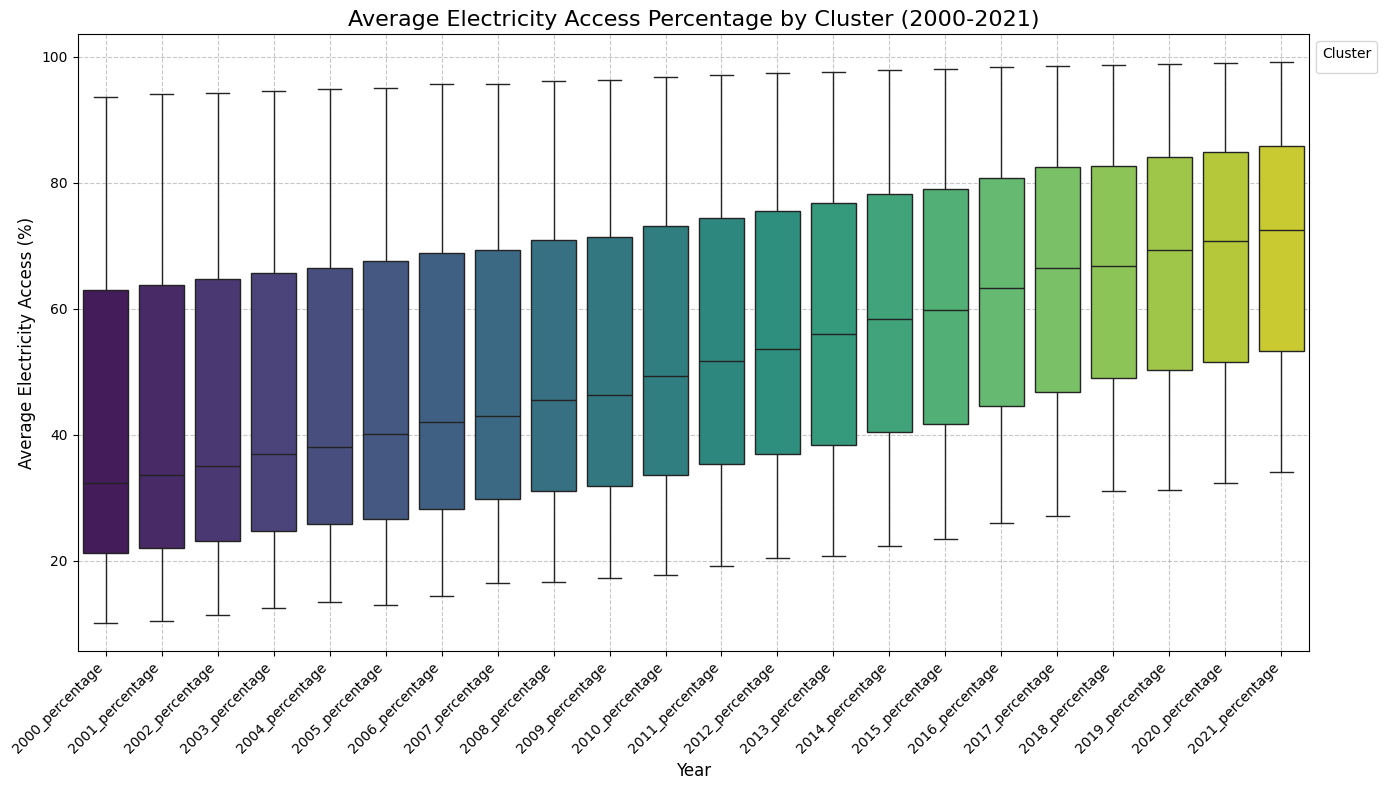

In [ ]:


# Assuming 'avg_access_by_cluster' is already calculated and transposed

# Plotting the bar plot for all clusters
plt.figure(figsize=(14, 8))

# Using seaborn barplot
sns.boxplot(data=avg_access_by_cluster, palette="viridis")

# Set plot title and labels
plt.title('Average Electricity Access Percentage by Cluster (2000-2021)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Electricity Access (%)', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a legend to differentiate the clusters
plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1, 1))

# Show grid for better clarity
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()


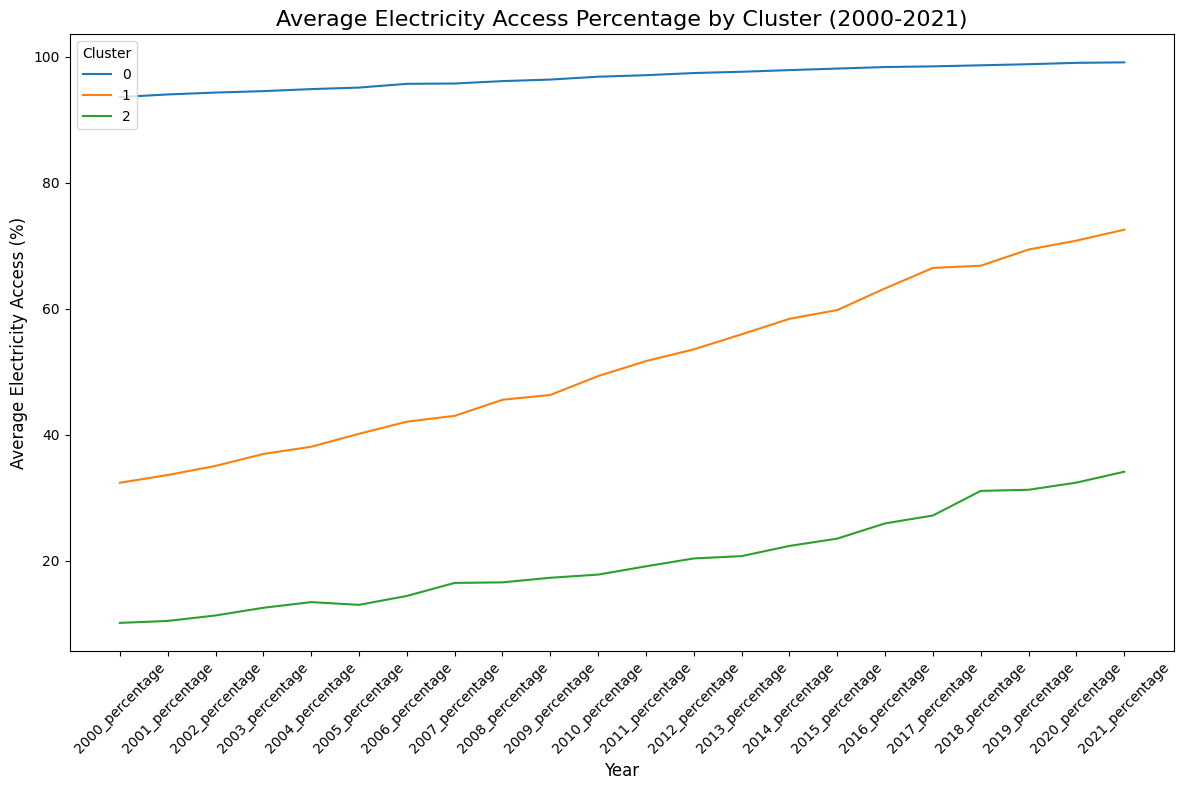

In [ ]:


# Assuming 'avg_access_by_cluster' is already calculated
# Transpose the DataFrame so that each cluster becomes a column and years are rows
avg_access_by_cluster = avg_access_by_cluster.transpose()

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=avg_access_by_cluster, dashes=False)

# Set plot labels and title
plt.title('Average Electricity Access Percentage by Cluster (2000-2021)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Electricity Access (%)', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels to make them readable
plt.legend(title='Cluster', loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:


# Assuming 'df' is your DataFrame and 'years_columns' has the year columns (2000-2021)
years_columns = [str(year) + "_percentage" for year in range(2000, 2022)]
data = df[years_columns]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Fit KMeans model (assuming you want 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)

# Predict clusters for each data point (row in the DataFrame)
df['Predicted_Cluster'] = kmeans.predict(scaled_data)

# Print the DataFrame with the predicted clusters
print(df[['Country/Regional and global averages', 'Predicted_Cluster']].head())


   Country/Regional and global averages  Predicted_Cluster
0                                     0                  1
1                                     1                  0
2                                     2                  0
4                                     3                  0
5                                     4                  2


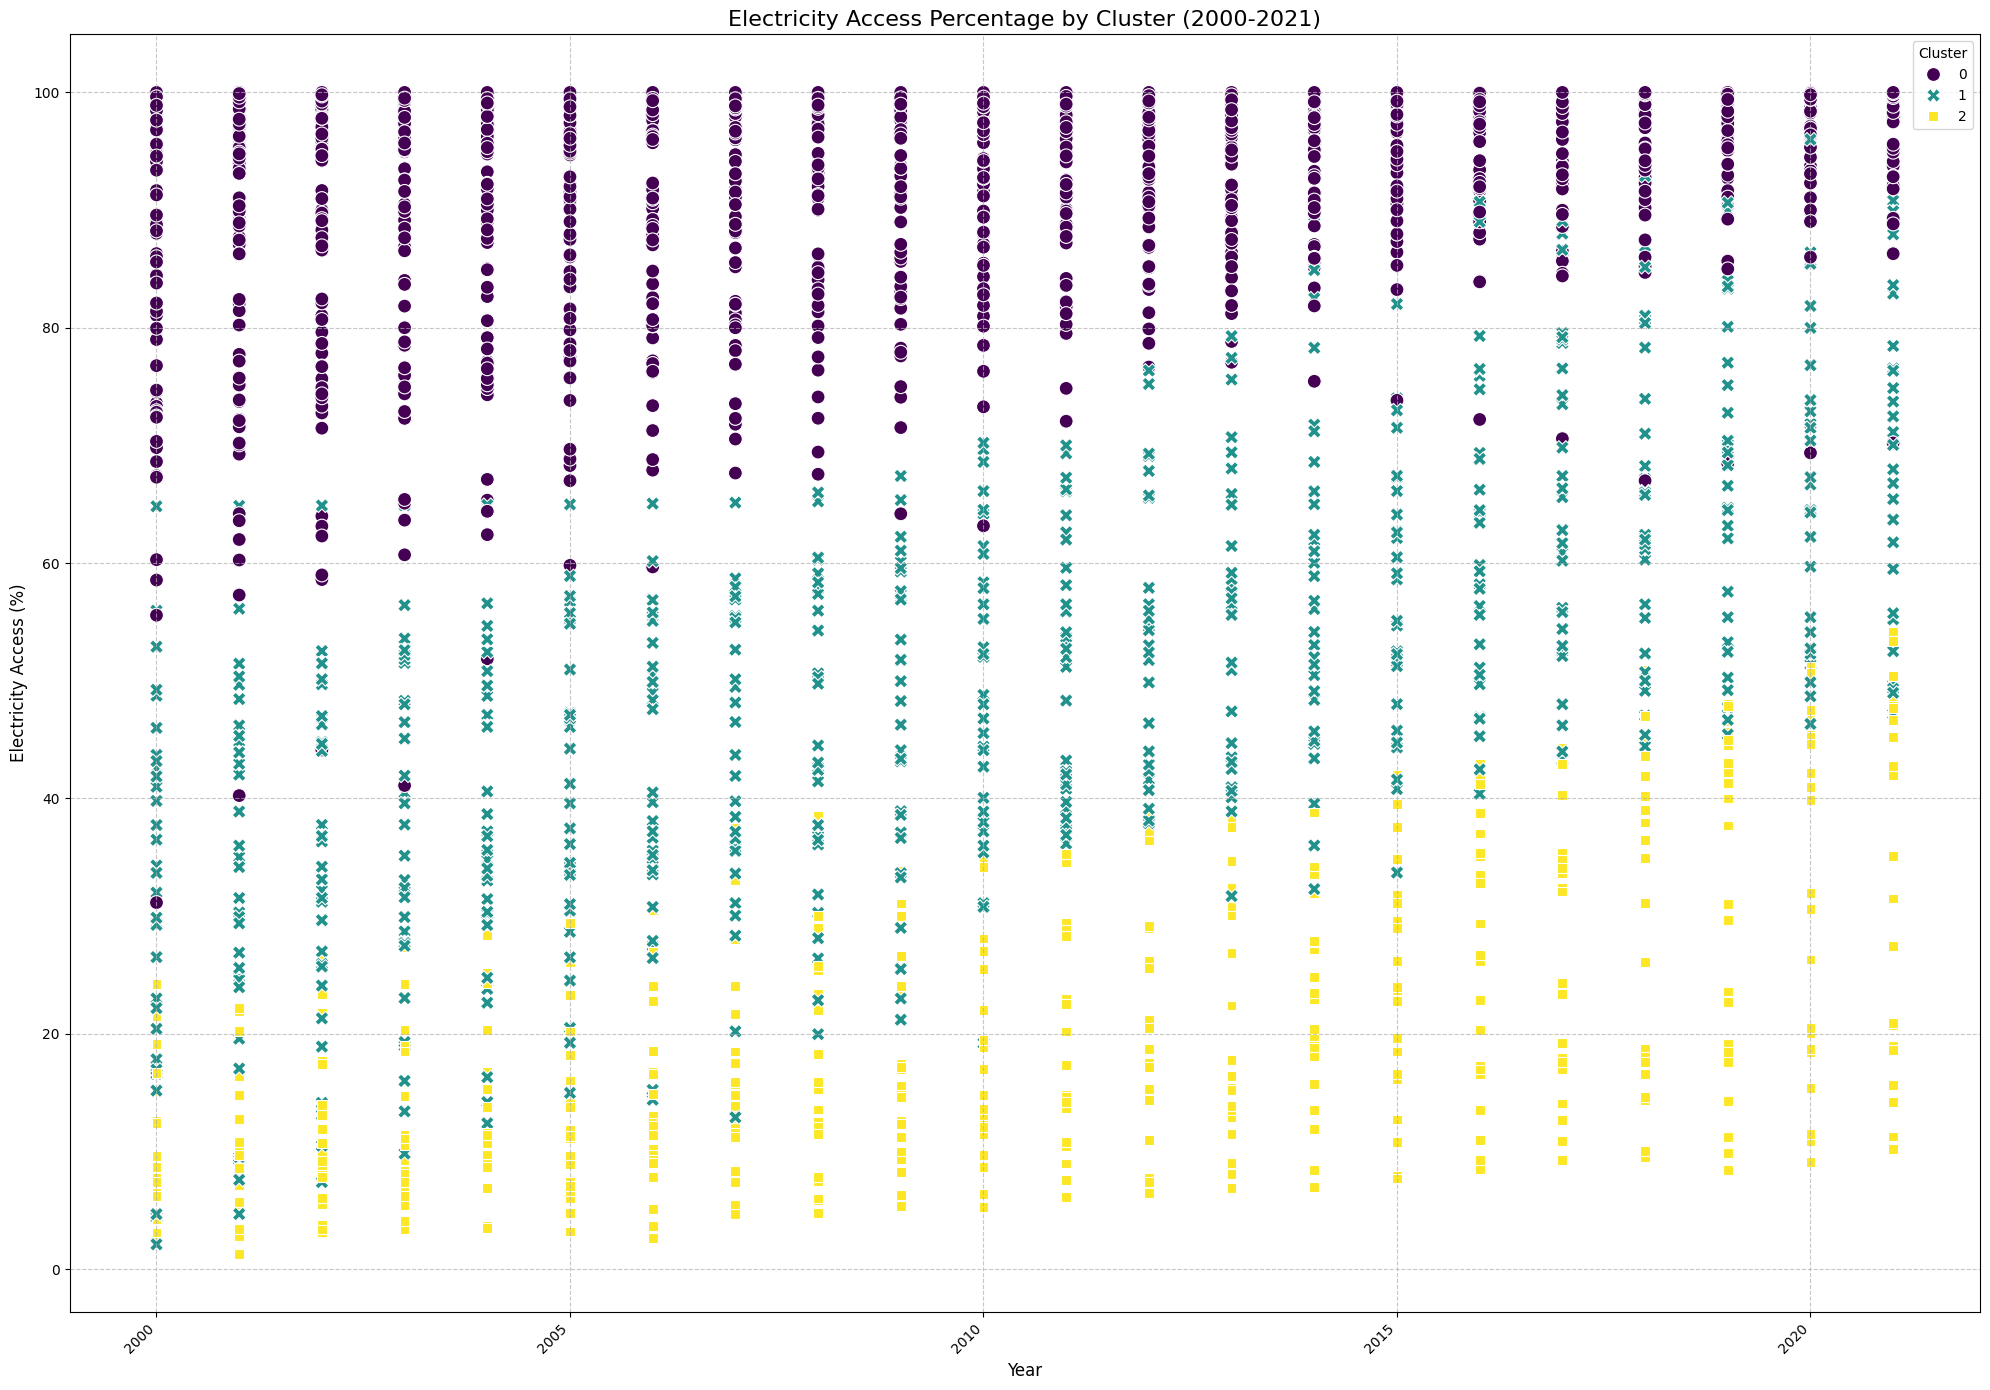

In [ ]:


# Assuming 'df' now has a 'Predicted_Cluster' column with cluster predictions
# We will use the years and predicted clusters to plot

# Create a new DataFrame with 'Cluster', 'Years', and 'Access Percentage' for plotting
df_melted = df.melt(id_vars=['Country/Regional and global averages', 'Predicted_Cluster'], 
                    value_vars=years_columns, 
                    var_name='Year', 
                    value_name='Electricity_Access_Percentage')

# Convert 'Year' column to numeric type for better plotting
df_melted['Year'] = df_melted['Year'].apply(lambda x: int(x.split('_')[0]))

# Plotting
plt.figure(figsize=(20, 14))
sns.scatterplot(data=df_melted, x='Year', y='Electricity_Access_Percentage', 
                hue='Predicted_Cluster', style='Predicted_Cluster', palette="viridis", s=100)

# Set plot title and labels
plt.title('Electricity Access Percentage by Cluster (2000-2021)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Electricity Access (%)', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the legend
plt.legend(title='Cluster')

# Show grid for clarity
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:

# Inertia (within-cluster sum of squares)
inertia = kmeans.inertia_
print(f"Inertia (Sum of squared distances): {inertia}")

# Silhouette Score (higher is better, closer to 1)
silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")


Inertia (Sum of squared distances): 435.3356559626562
Silhouette Score: 0.756804375236573
